<a href="https://colab.research.google.com/github/messias077/REP/blob/main/Problema_Arvores_Decisao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Heurística para escolher o melhor valor de cada característica**

In [1]:
# Importes necessários para todos os códigos
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import  Counter
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

In [2]:
# Carregando a base de dados para a primeira comparação

iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [3]:
# Implementação da árvore de decisão feita no vídeo

def impureza(y):
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result


def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores


def melhorValor(x, y):
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza


def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]


def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]


class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:], y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:], y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:, self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

In [4]:
# Árvore com heurística nova

def hn_melhorValor(x):
    media = np.mean(x)
    desvio_padrao = np.std(x)
    vpm = np.abs(x-media) <= desvio_padrao  # Valores perto da média
    return media, desvio_padrao, sum(vpm)

# Considerei como melhor característica a que tem mais valores perto da média
def hn_melhorCaracteristica(X):
    caracs = []  # Características
    lista_qtd_vpm = []  # Lista de quantidade de valores perto da média 
    for carac in range(X.shape[1]):
        media, desvio_padrao, qtd_vpm = hn_melhorValor(X[:,carac])
        caracs.append([carac, media, desvio_padrao])
        lista_qtd_vpm.append(qtd_vpm)
    ind_carac = np.argmax(lista_qtd_vpm)  # Índice da melhor característica

    # Retorna: A melhor característica, a média e o desvio padrão dela
    return caracs[ind_carac][0], caracs[ind_carac][1], caracs[ind_carac][2]


class ArvoreNova(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.carac, self.media, self.desvio_padrao = hn_melhorCaracteristica(X)
        vpm = np.abs(X[:,self.carac]-self.media) <= self.desvio_padrao
        if sum(vpm)>0 and sum(~vpm)>0:
            self.vpm = Arvore()  # árvore de valores perto da média 
            self.vpm.fit(X[vpm,:], y[vpm])
            self.vlm = Arvore()  # árvore de valores longe da média
            self.vlm.fit(X[~vpm,:], y[~vpm])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            vpm = np.abs(X[:,self.carac]-self.media) <= self.desvio_padrao
            y[vpm] = self.vpm.predict(X[vpm,:])
            y[~vpm] = self.vlm.predict(X[~vpm,:])
        return y


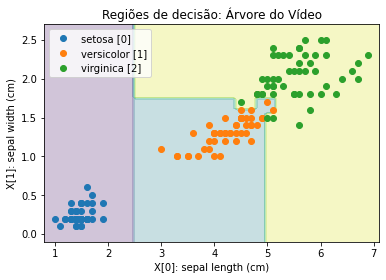

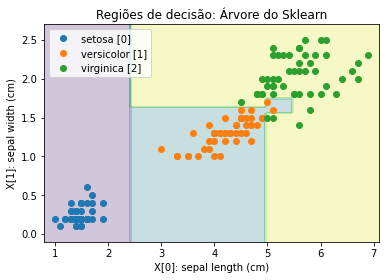

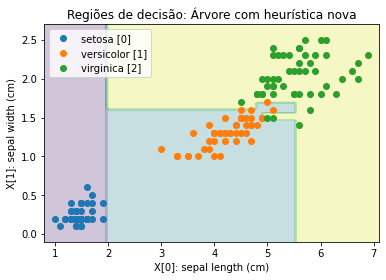

In [5]:
# Função para plotar as regiões de decisão

def plotDecisao(modelo, X, y, titulo):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
        plt.legend()
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.title(titulo)
    plt.show()

# Comparação das regiões de decisão
plotDecisao(Arvore(), X, y, "Regiões de decisão: Árvore do Vídeo")
plotDecisao(DecisionTreeClassifier(), X, y, "Regiões de decisão: Árvore do Sklearn")
plotDecisao(ArvoreNova(), X, y, "Regiões de decisão: Árvore com heurística nova")

In [ ]:
# Comparação utilizando validação cruzada

# Scores das árvores
scores_video = cross_validate(Arvore(), X, y)
scores_sklearn = cross_validate(DecisionTreeClassifier(), X, y)
scores_arvore_nova = cross_validate(ArvoreNova(), X, y)

print("     *** Resultados (Dataset Iris) ***")
print("     ---------------------------------\n")
print(f"Árvore do vídeo.............: {np.mean(scores_video['test_score'])}")
print(f"Árvore do Sklearn...........: {np.mean(scores_sklearn['test_score'])}")
print(f"Árvore com heurística nova..: {np.mean(scores_arvore_nova['test_score'])}")

     *** Resultados (Dataset Iris) ***
     ---------------------------------

Árvore do vídeo.............: 0.9533333333333334
Árvore do Sklearn...........: 0.9533333333333334
Árvore com heurística nova..: 0.96


In [ ]:
# Carregando a base de dados para a segunda comparação

# Informações sobre o dataset: https://www.kaggle.com/c/dat31-shuttle/data
# Local onde baixei: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html
# Obs.: Tive que tratar os dados, pois não vieram no formato csv. Também haviam valores 'NaN'
dados1 = pd.read_csv('shuttle.csv')

# Separando em features e target
X1 = dados1.iloc[:, 1:].values # Retira a coluna 'target'. Fica com as features de 1 a 9
y1 = dados1.iloc[:, 0].values # Pega somente a coluna 'target'

dados2 = load_breast_cancer()
X2 = dados2.data
y2 = dados2.target

dados3 = load_wine()
X3 = dados3.data
y3 = dados3.target

# Padronizando os dados das bases
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2 = scaler.fit_transform(X2)
X3 = scaler.fit_transform(X3)

In [ ]:
# Para facilitar a execução dos algoritmos
dados = [(X1, y1, 'Shuttle'), (X2, y2, 'Breast cancer'), (X3, y3, 'Wine')]

classificadores = [(Arvore(), 'Árvore do vídeo'), 
                   (DecisionTreeClassifier(), 'Árvore do Sklearn'),
                   (ArvoreNova(), 'Árvore com heurística nova')]

In [ ]:
# Faz as comparações utilizando a validação cruzada

print("             *** Resultados ***")
print("             ------------------\n")

# Roda todos os datasets para cada um dos classificadores
for d in dados:
    print(f'# Dataset..........: {d[2]} -> shape: {d[0].shape}; classes: {set(d[1])}]\n')

    for c in classificadores:
        scores = cross_validate(c[0], d[0], d[1])
        print(f"  Classificador....: {c[1]}")
        print(f"  Acurácia média...: {np.mean(scores['test_score'])}")
        print( "  Fit Time.........: %.5f seg." %(np.mean(scores['fit_time'])))
        print( "  Score Time.......: %.5f seg." %(np.mean(scores['score_time'])))
        print("\n")

    print('\n')

             *** Resultados ***
             ------------------

# Dataset..........: Shuttle -> shape: (42603, 9); classes: {1, 2, 3, 4, 5, 6, 7}]

  Classificador....: Árvore do vídeo
  Acurácia média...: 0.99924888414318
  Fit Time.........: 89.40508 seg.
  Score Time.......: 0.00995 seg.


  Classificador....: Árvore do Sklearn
  Acurácia média...: 0.9995774895824896
  Fit Time.........: 0.08827 seg.
  Score Time.......: 0.00138 seg.


  Classificador....: Árvore com heurística nova
  Acurácia média...: 0.9993662495254749
  Fit Time.........: 100.61708 seg.
  Score Time.......: 0.01158 seg.




# Dataset..........: Breast cancer -> shape: (569, 30); classes: {0, 1}]

  Classificador....: Árvore do vídeo
  Acurácia média...: 0.9191429902189101
  Fit Time.........: 3.58582 seg.
  Score Time.......: 0.00729 seg.


  Classificador....: Árvore do Sklearn
  Acurácia média...: 0.9191119391398852
  Fit Time.........: 0.00750 seg.
  Score Time.......: 0.00044 seg.


  Classificador....: Árv

# **Interpretação dos resultados**

Para a criação da heurística eu considerei como melhor característica a que tem mais valores perto da média. Para fazer este cálculo utilizei o trecho de código abaixo:

`vpm = np.abs(x-media) <= desvio_padrao  # Valores perto da média`<br><br>


Quando comparada com a árvore de decisão implementada nos vídeos e a do Sklearn, a árvore nova com a heurística criada teve acurácia resultante da validação cruzada similar às das outras duas. Também gerou gráficos de regiões de decisão similar aos gráficos daquelas árvores.<br><br>



Com relação ao tempo de resposta, tanto a árvore do vídeo quanto a nova árvore, tiveram tempo bem superior à da Sklearn tanto para treinar quanto para predizer. Acredito que a natureza "*brute force*" das heurísticas contribuíram para isso. Além disso, a quantidade de *features* também influenciou no resultado, por exemplo, o dataset "*Breast cancer*" que possui 30 *features* teve tempos de *fit* e *score* bem superiores à árvore do Sklearn. Já para o dataset "*Shuttle*", apesar de possuir somente 9 *features*, demorou muito por conta da grande quantidade de exemplos, são 42603 linhas.